In [1]:
# Import required libraries
import os
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple

# Deep Learning & Transformers
import torch
import torch.nn.functional as F
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
from datasets import Dataset, DatasetDict, Features, ClassLabel, Image as HFImage

# Data Processing
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    cohen_kappa_score, matthews_corrcoef,
    balanced_accuracy_score, top_k_accuracy_score
)
from sklearn.preprocessing import label_binarize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ All libraries imported successfully")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

✓ All libraries imported successfully
PyTorch Version: 2.9.0+cu126
CUDA Available: False


In [2]:
# ========== CONFIGURATION ==========
# Update these paths according to your setup

# Path to your trained model checkpoint
# This should contain: config.json, model.safetensors, preprocessor_config.json, etc.
MODEL_PATH = "/content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Explainability Worflows/Simple Explanability/convnextv2_cervical_v0.1/content/convnextv2_cervical/checkpoint-1015"  # UPDATE THIS!

# Path to your Sipakmed dataset
# Should contain subdirectories for each class with NLM_CLAHE processed images
DATASET_PATH = Path("/content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Preprocessed Datasets/Augmented Datasets/Augmented Dataset - Limited Enhancement")  # UPDATE THIS!

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch size for inference
BATCH_SIZE = 32

# Class names (should match your training)
CLASS_NAMES = [
    'im_Dyskeratotic',
    'im_Koilocytotic',
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial-Intermediate'
]

# Results output directory
OUTPUT_DIR = Path("./evaluation_results")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Device: {DEVICE}")
print(f"Model Path: {MODEL_PATH}")
print(f"Dataset Path: {DATASET_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")

Device: cpu
Model Path: /content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Explainability Worflows/Simple Explanability/convnextv2_cervical_v0.1/content/convnextv2_cervical/checkpoint-1015
Dataset Path: /content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Preprocessed Datasets/Augmented Datasets/Augmented Dataset - Limited Enhancement
Output Directory: evaluation_results


In [3]:
print("Loading model and processor...")

# Load the image processor
processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
print(f"✓ Processor loaded")

# Load the fine-tuned model
model = ConvNextV2ForImageClassification.from_pretrained(MODEL_PATH)
model = model.to(DEVICE)
model.eval()  # Set to evaluation mode
print(f"✓ Model loaded and moved to {DEVICE}")

# Display model information
print(f"\nModel Configuration:")
print(f"  - Number of classes: {model.config.num_labels}")
print(f"  - Image size: {model.config.image_size}")
print(f"  - Hidden sizes: {model.config.hidden_sizes}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading model and processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Processor loaded
✓ Model loaded and moved to cpu

Model Configuration:
  - Number of classes: 5
  - Image size: 224
  - Hidden sizes: [96, 192, 384, 768]
  - Total parameters: 27,870,341
  - Trainable parameters: 27,870,341


In [4]:
print("Loading and preparing dataset...")

# Find all NLM_CLAHE directories
nlm_dirs = set()

# Search for NLM_CLAHE directories
for child in DATASET_PATH.iterdir():
    if not child.is_dir():
        continue
    for sub in child.iterdir():
        if sub.is_dir() and sub.name.lower() == "nlm_clahe":
            nlm_dirs.add(sub.resolve())
            break

# Recursive fallback
for p in DATASET_PATH.rglob("*"):
    if p.is_dir() and p.name.lower() == "nlm_clahe":
        nlm_dirs.add(p.resolve())

if not nlm_dirs:
    raise FileNotFoundError(
        f"No 'NLM_CLAHE' directories found under {DATASET_PATH}. "
        "Please check your dataset path."
    )

print(f"Found {len(nlm_dirs)} NLM_CLAHE directories")

# Collect all images
rows = []
seen_paths = set()

for nlm in sorted(nlm_dirs):
    class_name = nlm.parent.name
    bmp_files = [p.resolve() for p in nlm.iterdir() if p.is_file() and p.suffix.lower() == ".bmp"]

    if not bmp_files:
        print(f"Warning: No .bmp files found in {nlm} (class: '{class_name}')")
        continue

    for p in bmp_files:
        sp = str(p)
        if sp not in seen_paths:
            seen_paths.add(sp)
            rows.append((sp, class_name))

# Create DataFrame
df = pd.DataFrame(rows, columns=["image_path", "label_name"])

if df.empty:
    raise RuntimeError("No .bmp files found in any NLM_CLAHE directories")

# Create label mapping
class_names_sorted = sorted(df["label_name"].unique().tolist())
label_to_id = {n: i for i, n in enumerate(class_names_sorted)}
id_to_label = {i: n for n, i in label_to_id.items()}
df["label"] = df["label_name"].map(label_to_id)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nDataset Statistics:")
print(f"  - Total images: {len(df)}")
print(f"  - Number of classes: {len(class_names_sorted)}")
print(f"  - Classes: {class_names_sorted}")
print(f"\nClass Distribution:")
print(df["label_name"].value_counts().sort_index())

Loading and preparing dataset...
Found 5 NLM_CLAHE directories

Dataset Statistics:
  - Total images: 4049
  - Number of classes: 5
  - Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']

Class Distribution:
label_name
im_Dyskeratotic                813
im_Koilocytotic                825
im_Metaplastic                 793
im_Parabasal                   787
im_Superficial-Intermediate    831
Name: count, dtype: int64


In [5]:
# Create train/val/test split (matching training split)
print("Creating data splits...")

train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# We'll primarily use the test set for evaluation
eval_df = test_df.reset_index(drop=True)
print(f"\nUsing test set ({len(eval_df)} images) for comprehensive evaluation")

Creating data splits...
Train size: 3239
Validation size: 405
Test size: 405

Using test set (405 images) for comprehensive evaluation


In [10]:
# Create HuggingFace Dataset
print("Creating HuggingFace Dataset...")

features = Features({
    "image": HFImage(),
    "label": ClassLabel(names=class_names_sorted)
})

eval_dataset = Dataset.from_dict({
    "image": eval_df["image_path"].tolist(),
    "label": eval_df["label"].tolist()
}).cast(features)

print(f"✓ Dataset created with {len(eval_dataset)} samples")

Creating HuggingFace Dataset...


Casting the dataset:   0%|          | 0/405 [00:00<?, ? examples/s]

✓ Dataset created with 405 samples


In [22]:
# Define preprocessing transforms
mean, std = processor.image_mean, processor.image_std

eval_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

def apply_transforms(example):
    """Apply transformations to images"""
    example["pixel_values"] = eval_transform(example["image"].convert("RGB"))
    return example

print("Creating HuggingFace Dataset...")
# Re-initialize eval_dataset to ensure 'image' column is present before mapping
features = Features({
    "image": HFImage(),
    "label": ClassLabel(names=class_names_sorted)
})

eval_dataset = Dataset.from_dict({
    "image": eval_df["image_path"].tolist(),
    "label": eval_df["label"].tolist()
}).cast(features)

print(f"✓ Dataset re-initialized with {len(eval_dataset)} samples")

# Apply transforms
eval_dataset = eval_dataset.map(
    apply_transforms,
    remove_columns=["image"]
)

# Set format to PyTorch tensors for pixel_values and labels
eval_dataset.set_format('torch', columns=['pixel_values', 'label'])

print("✓ Transforms applied and dataset format set to torch")

Creating HuggingFace Dataset...


Casting the dataset:   0%|          | 0/405 [00:00<?, ? examples/s]

✓ Dataset re-initialized with 405 samples


Map:   0%|          | 0/405 [00:00<?, ? examples/s]

✓ Transforms applied and dataset format set to torch


In [23]:
print("Running inference on test set...")

all_predictions = []
all_probabilities = []
all_labels = []

# Create DataLoader
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values_tensors = []
    labels = []
    for item in batch:
        pv = item['pixel_values']

        # At this point, pv should ideally be a torch.Tensor due to set_format('torch')
        # However, if there are still any wrapping issues, this will handle them more robustly.
        while isinstance(pv, list) and len(pv) > 0:
            if len(pv) > 1:
                # This case is highly unexpected if apply_transforms is working correctly
                print(f"Warning: unwrapping a list with more than one element for pixel_values. Taking the first. Type: {type(pv)}. Length: {len(pv)}. Element 0 type: {type(pv[0])}")
            pv = pv[0] # Take the first element, assuming it's the intended tensor

        if isinstance(pv, torch.Tensor):
            pixel_values_tensors.append(pv)
            labels.append(item['label'])
        else:
            print(f"Warning: Final pixel_values is not a torch.Tensor after unwrapping (type: {type(pv)}). Skipping this item.")
            continue

    if not pixel_values_tensors:
        raise ValueError("No valid samples in batch after filtering for non-tensor pixel_values.")

    pixel_values = torch.stack(pixel_values_tensors)
    labels = torch.tensor(labels)
    return {'pixel_values': pixel_values, 'labels': labels}

dataloader = DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

# Run inference
with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader):
        pixel_values = batch['pixel_values'].to(DEVICE)
        labels = batch['labels']

        # Forward pass
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits

        # Get probabilities
        probs = F.softmax(logits, dim=-1).cpu().numpy()
        predictions = logits.argmax(dim=-1).cpu().numpy()

        all_predictions.extend(predictions)
        all_probabilities.extend(probs)
        all_labels.extend(labels.numpy())

        if (batch_idx + 1) % 5 == 0:
            print(f"  Processed {(batch_idx + 1) * BATCH_SIZE}/{len(eval_dataset)} samples")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)

print(f"\n✓ Inference complete!")
print(f"  Predictions shape: {all_predictions.shape}")
print(f"  Probabilities shape: {all_probabilities.shape}")
print(f"  Labels shape: {all_labels.shape}")

Running inference on test set...
  Processed 160/405 samples
  Processed 320/405 samples

✓ Inference complete!
  Predictions shape: (405,)
  Probabilities shape: (405, 5)
  Labels shape: (405,)


In [25]:
# Calculate basic metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision_macro = precision_score(all_labels, all_predictions, average='macro')
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
f1_macro = f1_score(all_labels, all_predictions, average='macro')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

print("="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"\nAccuracy:              {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nPrecision (Macro):     {precision_macro:.4f}")
print(f"Precision (Weighted):  {precision_weighted:.4f}")
print(f"\nRecall (Macro):        {recall_macro:.4f}")
print(f"Recall (Weighted):     {recall_weighted:.4f}")
print(f"\nF1-Score (Macro):      {f1_macro:.4f}")
print(f"F1-Score (Weighted):   {f1_weighted:.4f}")
print("="*60)

OVERALL PERFORMANCE METRICS

Accuracy:              0.9630 (96.30%)

Precision (Macro):     0.9633
Precision (Weighted):  0.9632

Recall (Macro):        0.9632
Recall (Weighted):     0.9630

F1-Score (Macro):      0.9632
F1-Score (Weighted):   0.9630


In [24]:
# Calculate basic metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision_macro = precision_score(all_labels, all_predictions, average='macro')
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
f1_macro = f1_score(all_labels, all_predictions, average='macro')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

print("="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"\nAccuracy:              {accuracy:.4f} ({accuracy*100:.2f}%) Kishan")
print(f"\nPrecision (Macro):     {precision_macro:.4f}")
print(f"Precision (Weighted):  {precision_weighted:.4f}")
print(f"\nRecall (Macro):        {recall_macro:.4f}")
print(f"Recall (Weighted):     {recall_weighted:.4f}")
print(f"\nF1-Score (Macro):      {f1_macro:.4f}")
print(f"F1-Score (Weighted):   {f1_weighted:.4f}")
print("="*60)

OVERALL PERFORMANCE METRICS

Accuracy:              0.9630 (96.30%) Kishan

Precision (Macro):     0.9633
Precision (Weighted):  0.9632

Recall (Macro):        0.9632
Recall (Weighted):     0.9630

F1-Score (Macro):      0.9632
F1-Score (Weighted):   0.9630


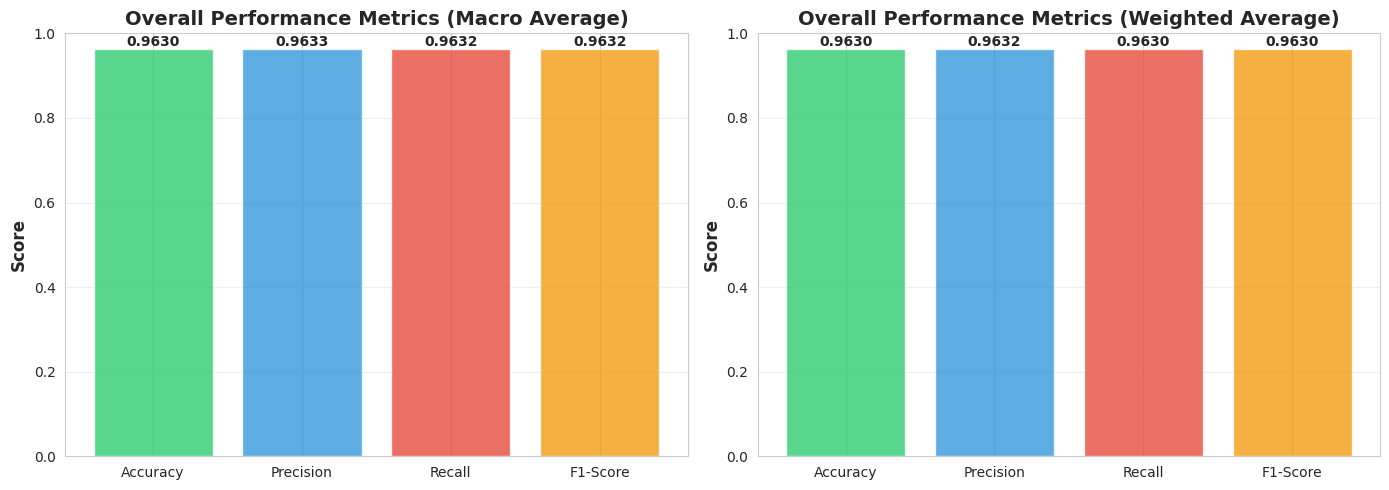

✓ Saved: evaluation_results/overall_metrics.png


In [26]:
# Visualize overall metrics
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Macro metrics
metrics_macro = {
    'Accuracy': accuracy,
    'Precision': precision_macro,
    'Recall': recall_macro,
    'F1-Score': f1_macro
}

colors_macro = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars1 = ax[0].bar(metrics_macro.keys(), metrics_macro.values(), color=colors_macro, alpha=0.8)
ax[0].set_ylim([0, 1.0])
ax[0].set_ylabel('Score', fontsize=12, fontweight='bold')
ax[0].set_title('Overall Performance Metrics (Macro Average)', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontweight='bold')

# Plot 2: Weighted metrics
metrics_weighted = {
    'Accuracy': accuracy,
    'Precision': precision_weighted,
    'Recall': recall_weighted,
    'F1-Score': f1_weighted
}

bars2 = ax[1].bar(metrics_weighted.keys(), metrics_weighted.values(), color=colors_macro, alpha=0.8)
ax[1].set_ylim([0, 1.0])
ax[1].set_ylabel('Score', fontsize=12, fontweight='bold')
ax[1].set_title('Overall Performance Metrics (Weighted Average)', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'overall_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'overall_metrics.png'}")

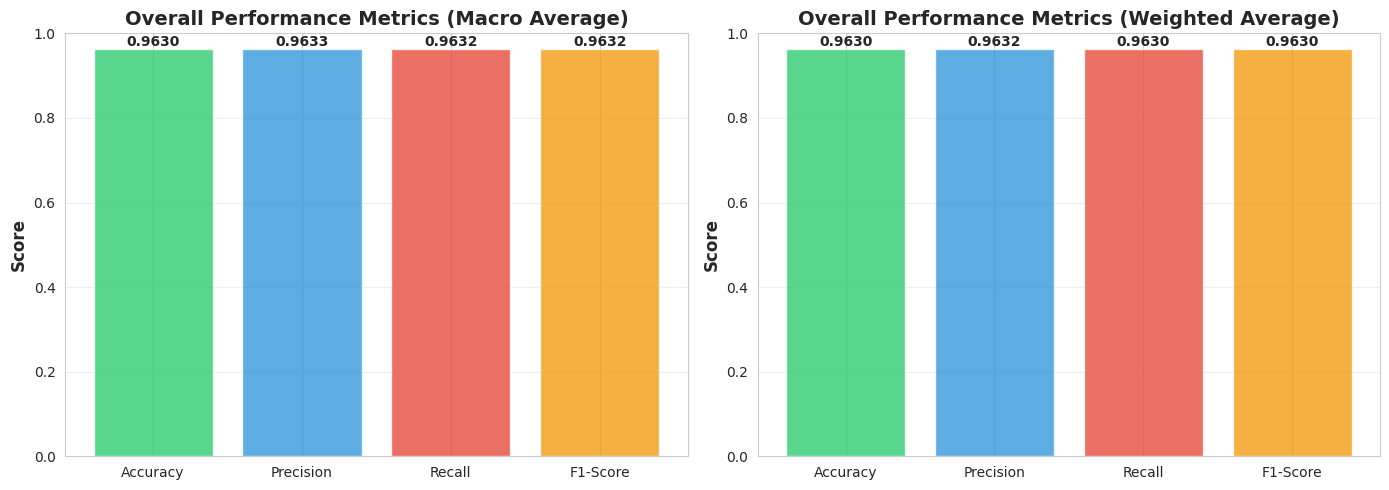

✓ Saved: evaluation_results/overall_metrics.png


In [27]:
# Visualize overall metrics
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Macro metrics
metrics_macro = {
    'Accuracy': accuracy,
    'Precision': precision_macro,
    'Recall': recall_macro,
    'F1-Score': f1_macro
}

colors_macro = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars1 = ax[0].bar(metrics_macro.keys(), metrics_macro.values(), color=colors_macro, alpha=0.8)
ax[0].set_ylim([0, 1.0])
ax[0].set_ylabel('Score', fontsize=12, fontweight='bold')
ax[0].set_title('Overall Performance Metrics (Macro Average)', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontweight='bold')

# Plot 2: Weighted metrics
metrics_weighted = {
    'Accuracy': accuracy,
    'Precision': precision_weighted,
    'Recall': recall_weighted,
    'F1-Score': f1_weighted
}

bars2 = ax[1].bar(metrics_weighted.keys(), metrics_weighted.values(), color=colors_macro, alpha=0.8)
ax[1].set_ylim([0, 1.0])
ax[1].set_ylabel('Score', fontsize=12, fontweight='bold')
ax[1].set_title('Overall Performance Metrics (Weighted Average)', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'overall_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'overall_metrics.png'}")

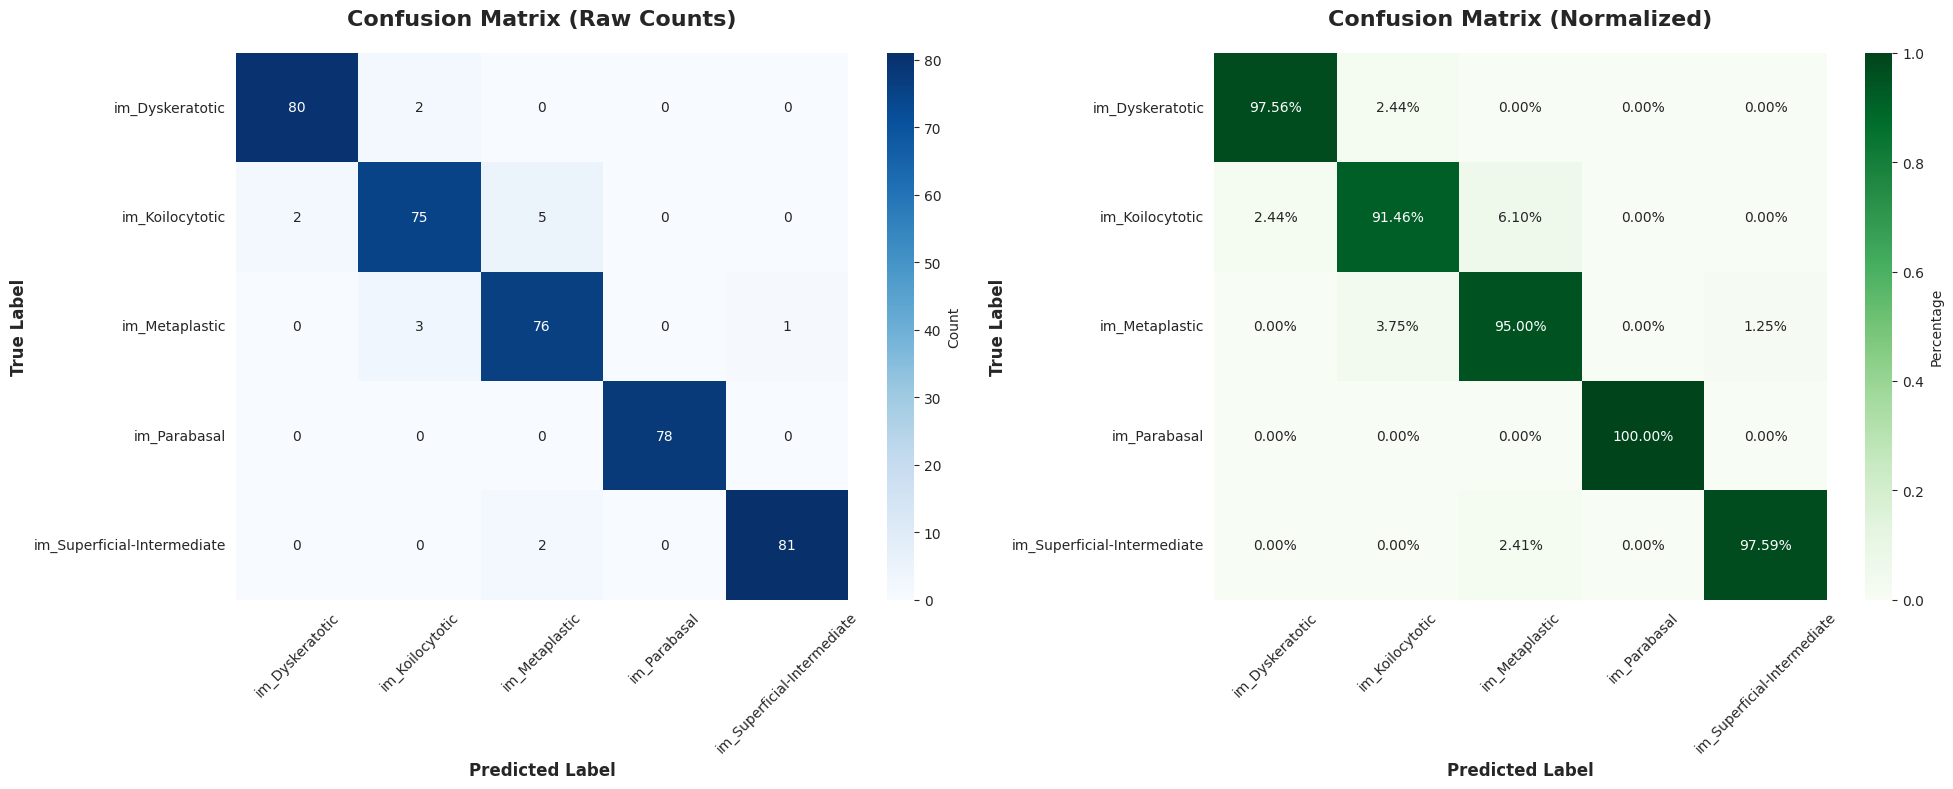

✓ Saved: evaluation_results/confusion_matrices.png


In [28]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = confusion_matrix(all_labels, all_predictions, normalize='true')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_sorted,
            yticklabels=class_names_sorted,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names_sorted,
            yticklabels=class_names_sorted,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'confusion_matrices.png'}")

In [29]:
# Analyze misclassifications from confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)

for i, true_class in enumerate(class_names_sorted):
    print(f"\n{true_class}:")
    print(f"  Correctly classified: {cm[i, i]} / {cm[i].sum()} ({cm_normalized[i, i]*100:.2f}%)")

    # Find main misclassifications
    misclassified_indices = np.argsort(cm[i])[::-1]
    for j in misclassified_indices:
        if i != j and cm[i, j] > 0:
            print(f"  Misclassified as {class_names_sorted[j]}: {cm[i, j]} ({cm_normalized[i, j]*100:.2f}%)")


CONFUSION MATRIX ANALYSIS

im_Dyskeratotic:
  Correctly classified: 80 / 82 (97.56%)
  Misclassified as im_Koilocytotic: 2 (2.44%)

im_Koilocytotic:
  Correctly classified: 75 / 82 (91.46%)
  Misclassified as im_Metaplastic: 5 (6.10%)
  Misclassified as im_Dyskeratotic: 2 (2.44%)

im_Metaplastic:
  Correctly classified: 76 / 80 (95.00%)
  Misclassified as im_Koilocytotic: 3 (3.75%)
  Misclassified as im_Superficial-Intermediate: 1 (1.25%)

im_Parabasal:
  Correctly classified: 78 / 78 (100.00%)

im_Superficial-Intermediate:
  Correctly classified: 81 / 83 (97.59%)
  Misclassified as im_Metaplastic: 2 (2.41%)


In [30]:
# Binarize labels for multi-class ROC
n_classes = len(class_names_sorted)
y_true_bin = label_binarize(all_labels, classes=range(n_classes))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print("ROC AUC Scores:")
print(f"  Micro-average: {roc_auc['micro']:.4f}")
print(f"  Macro-average: {roc_auc['macro']:.4f}")
for i, class_name in enumerate(class_names_sorted):
    print(f"  {class_name}: {roc_auc[i]:.4f}")

ROC AUC Scores:
  Micro-average: 0.9949
  Macro-average: 0.9958
  im_Dyskeratotic: 0.9996
  im_Koilocytotic: 0.9855
  im_Metaplastic: 0.9890
  im_Parabasal: 1.0000
  im_Superficial-Intermediate: 0.9989


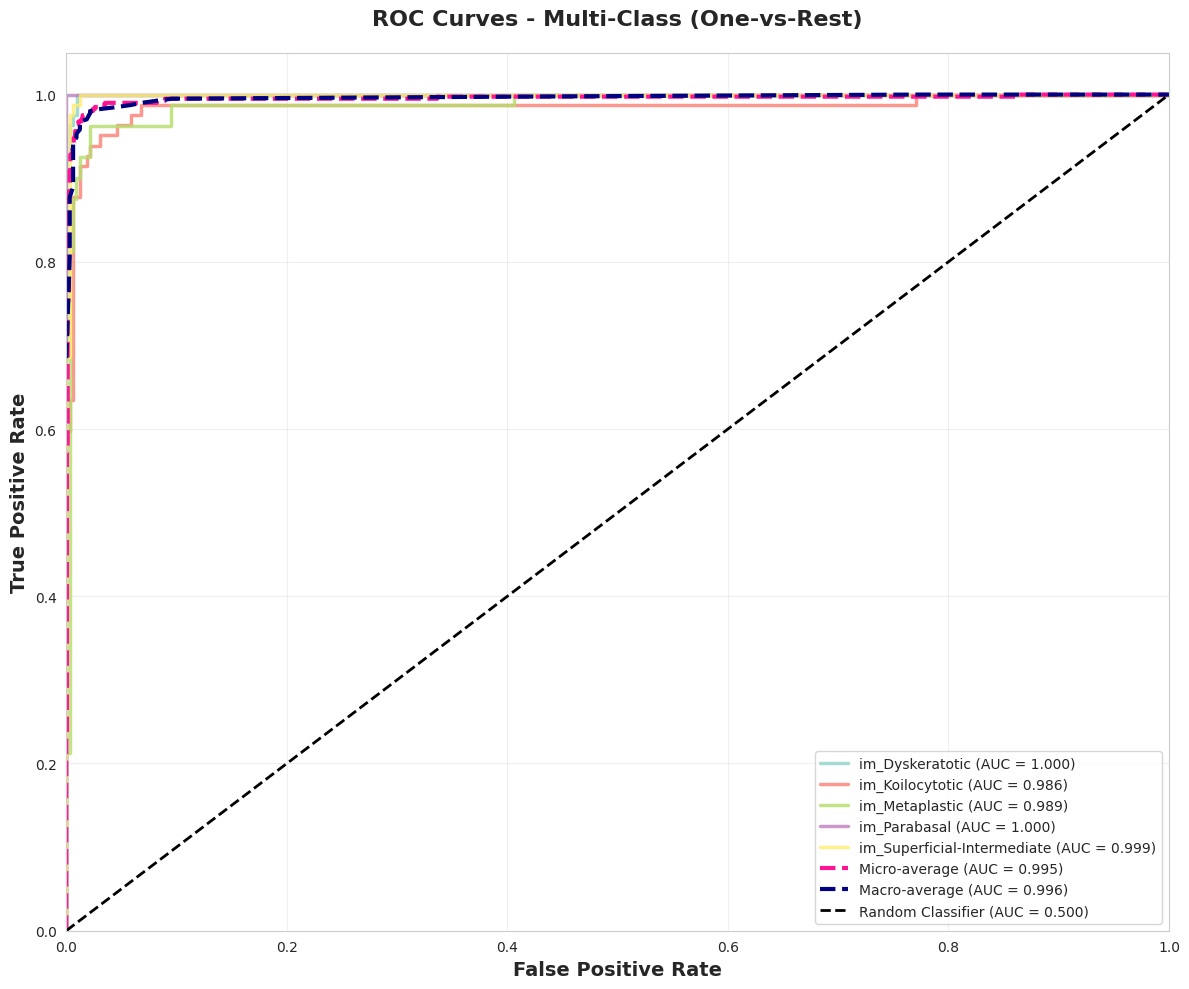

✓ Saved: evaluation_results/roc_curves.png


In [31]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors
colors = plt.cm.Set3(np.linspace(0, 1, n_classes))

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, class_names_sorted):
    ax.plot(fpr[i], tpr[i], color=color, lw=2.5, alpha=0.8,
            label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

# Plot micro and macro averages
ax.plot(fpr["micro"], tpr["micro"],
        label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
        color='deeppink', linestyle='--', linewidth=3)

ax.plot(fpr["macro"], tpr["macro"],
        label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
        color='navy', linestyle='--', linewidth=3)

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - Multi-Class (One-vs-Rest)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'roc_curves.png'}")

In [32]:
# Calculate Precision-Recall curve for each class
precision_dict = dict()
recall_dict = dict()
avg_precision = dict()

for i in range(n_classes):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(
        y_true_bin[:, i], all_probabilities[:, i]
    )
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probabilities[:, i])

# Micro-average
precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(), all_probabilities.ravel()
)
avg_precision["micro"] = average_precision_score(y_true_bin, all_probabilities, average="micro")

# Macro-average
avg_precision["macro"] = average_precision_score(y_true_bin, all_probabilities, average="macro")

print("Average Precision Scores:")
print(f"  Micro-average: {avg_precision['micro']:.4f}")
print(f"  Macro-average: {avg_precision['macro']:.4f}")
for i, class_name in enumerate(class_names_sorted):
    print(f"  {class_name}: {avg_precision[i]:.4f}")

Average Precision Scores:
  Micro-average: 0.9867
  Macro-average: 0.9852
  im_Dyskeratotic: 0.9984
  im_Koilocytotic: 0.9704
  im_Metaplastic: 0.9620
  im_Parabasal: 1.0000
  im_Superficial-Intermediate: 0.9950


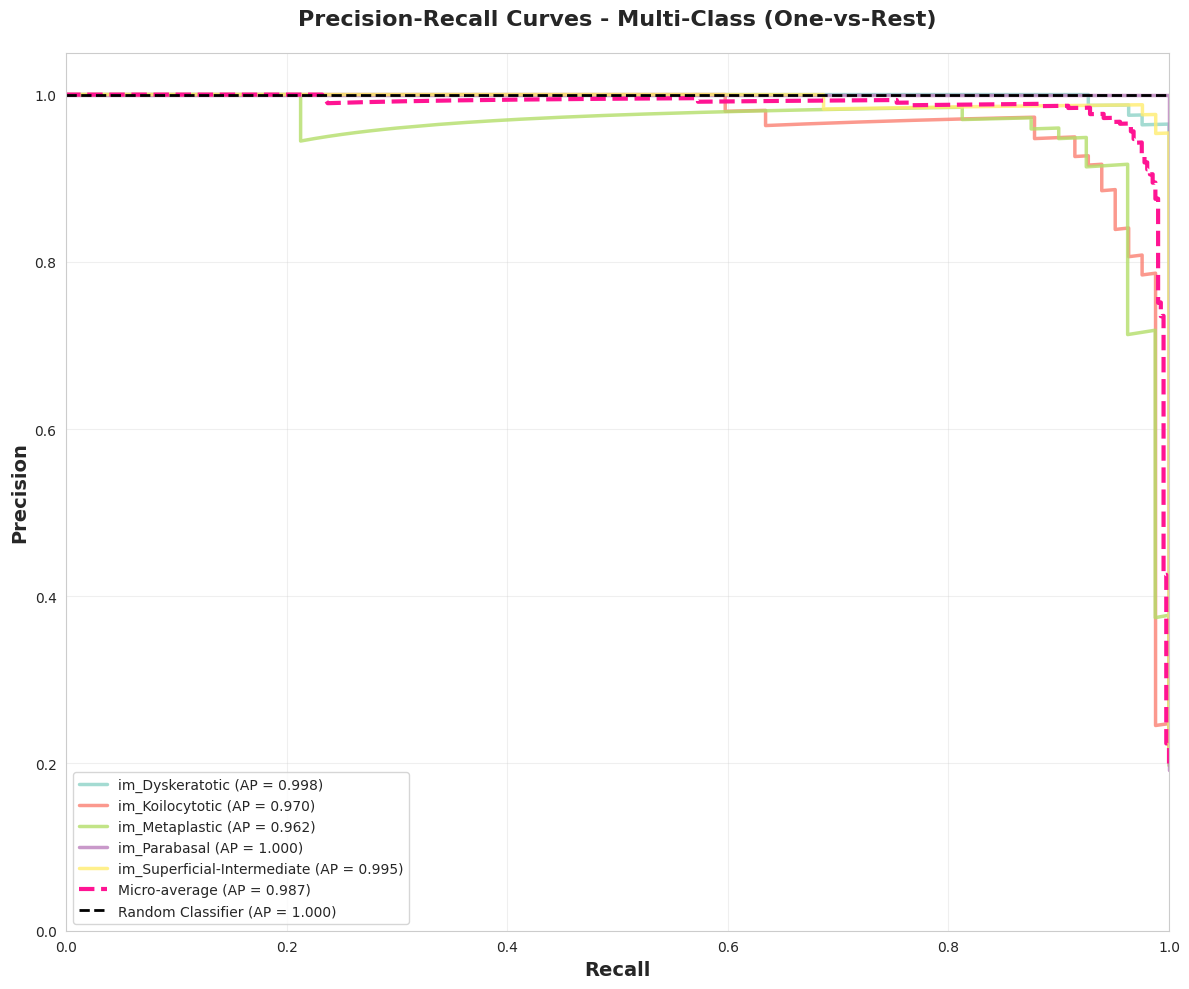

✓ Saved: evaluation_results/precision_recall_curves.png


In [33]:
# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(12, 10))

# Plot PR curve for each class
for i, color, class_name in zip(range(n_classes), colors, class_names_sorted):
    ax.plot(recall_dict[i], precision_dict[i], color=color, lw=2.5, alpha=0.8,
            label=f'{class_name} (AP = {avg_precision[i]:.3f})')

# Plot micro-average
ax.plot(recall_dict["micro"], precision_dict["micro"],
        label=f'Micro-average (AP = {avg_precision["micro"]:.3f})',
        color='deeppink', linestyle='--', linewidth=3)

# Plot baseline (random classifier for balanced dataset)
baseline = y_true_bin.sum() / len(y_true_bin)
ax.plot([0, 1], [baseline, baseline], 'k--', lw=2,
        label=f'Random Classifier (AP = {baseline:.3f})')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Curves - Multi-Class (One-vs-Rest)',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc="lower left", fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'precision_recall_curves.png'}")

In [34]:
# Generate detailed classification report
report = classification_report(
    all_labels,
    all_predictions,
    target_names=class_names_sorted,
    output_dict=True
)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(report_df.to_string())
print("="*80)

# Save to CSV
report_df.to_csv(OUTPUT_DIR / 'classification_report.csv')
print(f"\n✓ Saved: {OUTPUT_DIR / 'classification_report.csv'}")


DETAILED CLASSIFICATION REPORT
                             precision    recall  f1-score     support
im_Dyskeratotic               0.975610  0.975610  0.975610   82.000000
im_Koilocytotic               0.937500  0.914634  0.925926   82.000000
im_Metaplastic                0.915663  0.950000  0.932515   80.000000
im_Parabasal                  1.000000  1.000000  1.000000   78.000000
im_Superficial-Intermediate   0.987805  0.975904  0.981818   83.000000
accuracy                      0.962963  0.962963  0.962963    0.962963
macro avg                     0.963315  0.963230  0.963174  405.000000
weighted avg                  0.963249  0.962963  0.963008  405.000000

✓ Saved: evaluation_results/classification_report.csv


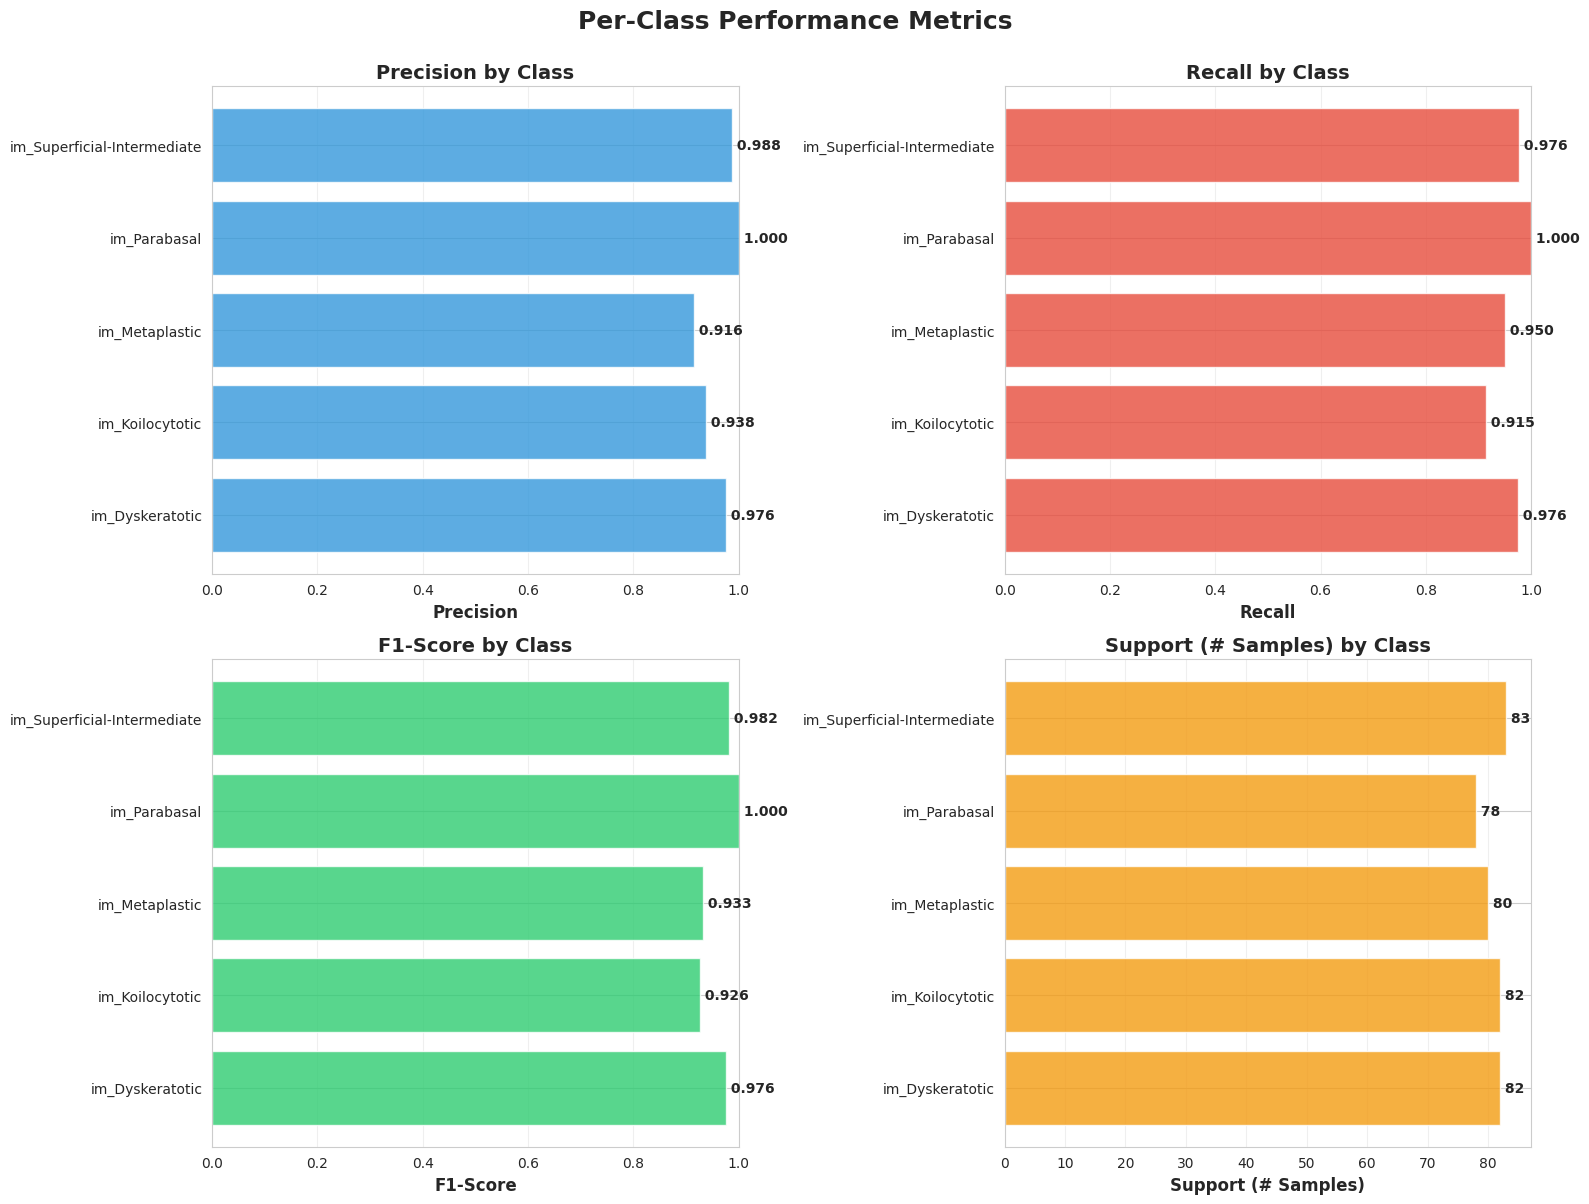

✓ Saved: evaluation_results/per_class_metrics.png


In [35]:
# Visualize per-class metrics
class_metrics = report_df.iloc[:-3]  # Exclude macro avg, weighted avg, accuracy rows

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Per-Class Performance Metrics', fontsize=18, fontweight='bold', y=1.00)

metrics_to_plot = ['precision', 'recall', 'f1-score', 'support']
metric_titles = ['Precision', 'Recall', 'F1-Score', 'Support (# Samples)']
metric_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, metric_titles, metric_colors)):
    ax = axes[idx // 2, idx % 2]

    values = class_metrics[metric].values
    bars = ax.barh(class_names_sorted, values, color=color, alpha=0.8)

    # Add value labels
    for bar, val in zip(bars, values):
        width = bar.get_width()
        label_format = f'{val:.3f}' if metric != 'support' else f'{int(val)}'
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f' {label_format}',
                ha='left', va='center', fontweight='bold')

    ax.set_xlabel(title, fontsize=12, fontweight='bold')
    ax.set_title(f'{title} by Class', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    if metric != 'support':
        ax.set_xlim([0, 1.0])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'per_class_metrics.png'}")

In [36]:
# Identify misclassified samples
misclassified_mask = all_predictions != all_labels
misclassified_indices = np.where(misclassified_mask)[0]
correctly_classified_indices = np.where(~misclassified_mask)[0]

print(f"Total samples: {len(all_labels)}")
print(f"Correctly classified: {len(correctly_classified_indices)} ({len(correctly_classified_indices)/len(all_labels)*100:.2f}%)")
print(f"Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(all_labels)*100:.2f}%)")

Total samples: 405
Correctly classified: 390 (96.30%)
Misclassified: 15 (3.70%)


In [37]:
# Analyze misclassification patterns
misclassification_patterns = []

for idx in misclassified_indices:
    true_label = all_labels[idx]
    pred_label = all_predictions[idx]
    confidence = all_probabilities[idx, pred_label]
    true_prob = all_probabilities[idx, true_label]

    misclassification_patterns.append({
        'index': idx,
        'true_class': class_names_sorted[true_label],
        'predicted_class': class_names_sorted[pred_label],
        'confidence': confidence,
        'true_class_prob': true_prob,
        'margin': confidence - true_prob
    })

misclass_df = pd.DataFrame(misclassification_patterns)

# Show top misclassifications by confidence
print("\nTop 10 Most Confident Misclassifications:")
print(misclass_df.nlargest(10, 'confidence')[['true_class', 'predicted_class', 'confidence', 'true_class_prob']].to_string())

# Save misclassifications
misclass_df.to_csv(OUTPUT_DIR / 'misclassifications.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR / 'misclassifications.csv'}")


Top 10 Most Confident Misclassifications:
                     true_class              predicted_class  confidence  true_class_prob
10              im_Koilocytotic               im_Metaplastic    0.999974         0.000003
14               im_Metaplastic  im_Superficial-Intermediate    0.999946         0.000014
7                im_Metaplastic              im_Koilocytotic    0.999885         0.000101
5                im_Metaplastic              im_Koilocytotic    0.999869         0.000111
0               im_Koilocytotic               im_Metaplastic    0.998753         0.001198
3               im_Koilocytotic              im_Dyskeratotic    0.994442         0.005412
6               im_Dyskeratotic              im_Koilocytotic    0.982745         0.007827
4               im_Koilocytotic               im_Metaplastic    0.981588         0.018353
12              im_Dyskeratotic              im_Koilocytotic    0.981124         0.011727
1   im_Superficial-Intermediate               im_Metaplas

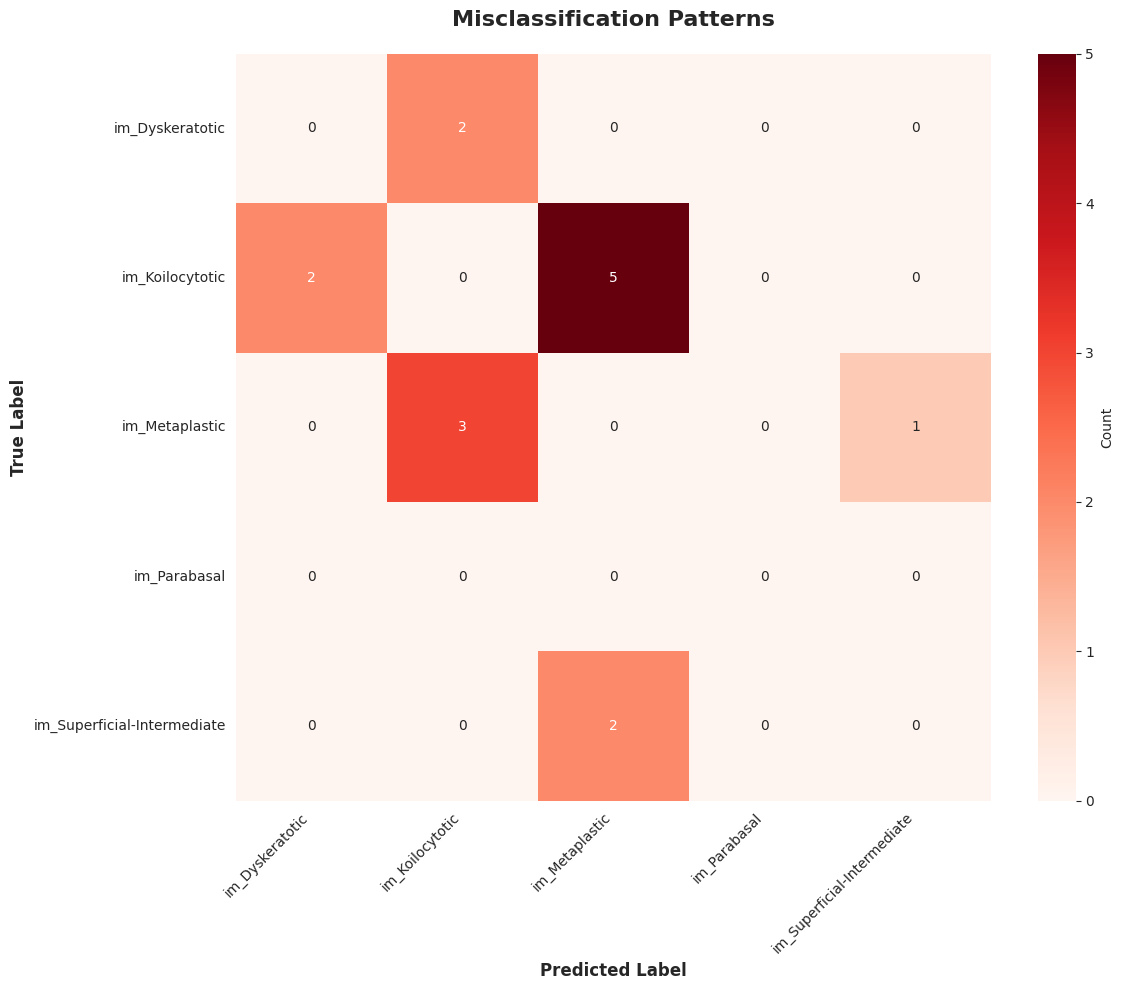

✓ Saved: evaluation_results/misclassification_patterns.png


In [38]:
# Visualize misclassification patterns
misclass_matrix = pd.crosstab(
    misclass_df['true_class'],
    misclass_df['predicted_class']
).reindex(index=class_names_sorted, columns=class_names_sorted, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(misclass_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names_sorted,
            yticklabels=class_names_sorted,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Misclassification Patterns', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'misclassification_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'misclassification_patterns.png'}")

In [39]:
# Get confidence scores (max probability)
confidence_scores = np.max(all_probabilities, axis=1)

# Separate correct and incorrect predictions
correct_confidences = confidence_scores[~misclassified_mask]
incorrect_confidences = confidence_scores[misclassified_mask]

print(f"Average confidence (correct predictions): {correct_confidences.mean():.4f} ± {correct_confidences.std():.4f}")
print(f"Average confidence (incorrect predictions): {incorrect_confidences.mean():.4f} ± {incorrect_confidences.std():.4f}")

Average confidence (correct predictions): 0.9950 ± 0.0323
Average confidence (incorrect predictions): 0.9356 ± 0.0986


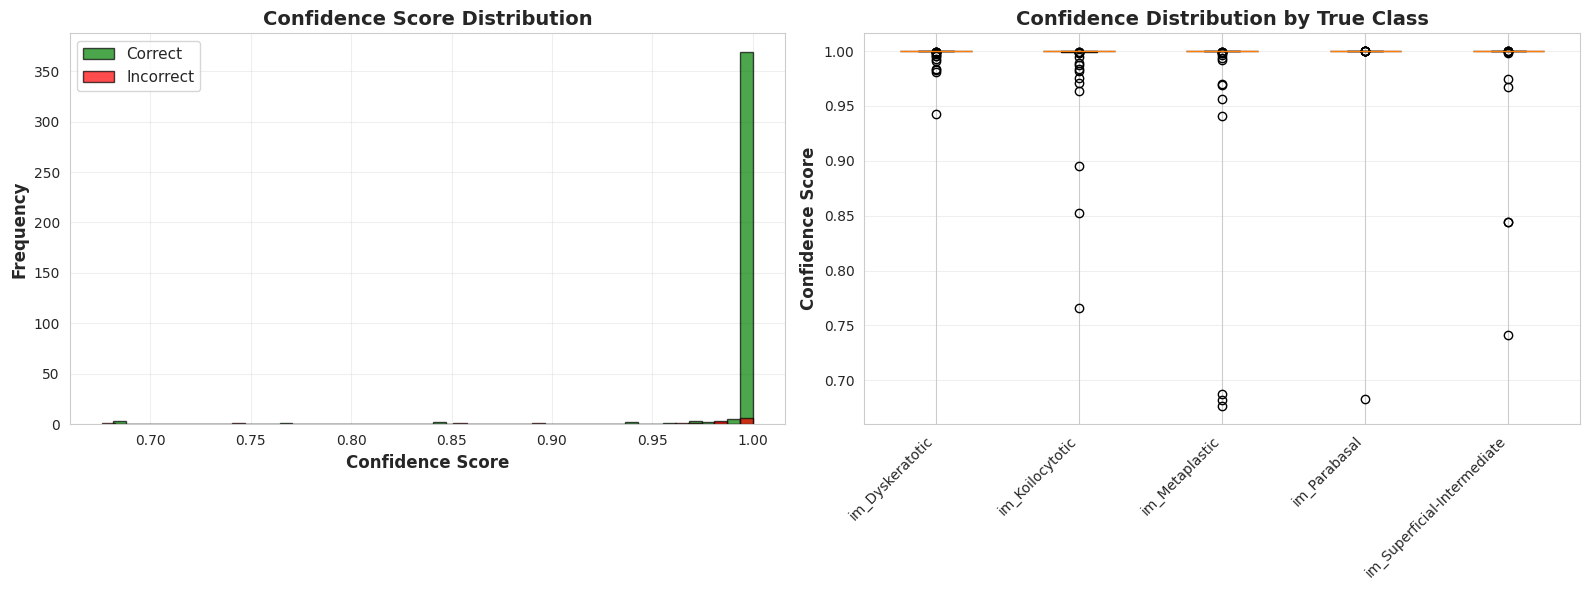

✓ Saved: evaluation_results/confidence_distribution.png


In [40]:
# Visualize confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram
axes[0].hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: Box plot by class
confidence_by_class = []
for i, class_name in enumerate(class_names_sorted):
    class_mask = all_labels == i
    confidence_by_class.append(confidence_scores[class_mask])

bp = axes[1].boxplot(confidence_by_class, labels=class_names_sorted, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Distribution by True Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'confidence_distribution.png'}")

In [41]:
# Calculate top-k accuracy for k = 1, 2, 3
topk_accuracies = []

for k in range(1, min(n_classes + 1, 4)):
    top_k_acc = top_k_accuracy_score(all_labels, all_probabilities, k=k)
    topk_accuracies.append(top_k_acc)
    print(f"Top-{k} Accuracy: {top_k_acc:.4f} ({top_k_acc*100:.2f}%)")

Top-1 Accuracy: 0.9630 (96.30%)
Top-2 Accuracy: 0.9901 (99.01%)
Top-3 Accuracy: 0.9975 (99.75%)


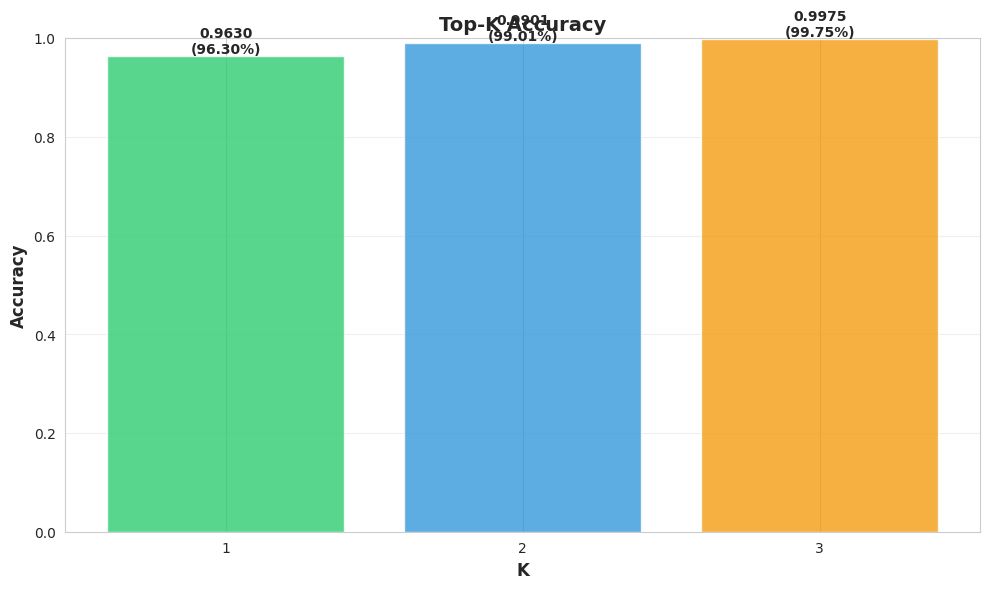

✓ Saved: evaluation_results/topk_accuracy.png


In [42]:
# Visualize top-k accuracy
fig, ax = plt.subplots(figsize=(10, 6))

k_values = list(range(1, len(topk_accuracies) + 1))
bars = ax.bar(k_values, topk_accuracies, color=['#2ecc71', '#3498db', '#f39c12'], alpha=0.8)

# Add value labels
for bar, acc in zip(bars, topk_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Top-K Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(k_values)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'topk_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'topk_accuracy.png'}")

In [43]:
# Calculate advanced metrics
kappa = cohen_kappa_score(all_labels, all_predictions)
mcc = matthews_corrcoef(all_labels, all_predictions)
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

# Calculate sensitivity and specificity for each class
sensitivities = []
specificities = []

for i in range(n_classes):
    # Binary classification: class i vs rest
    true_binary = (all_labels == i).astype(int)
    pred_binary = (all_predictions == i).astype(int)

    tn = np.sum((true_binary == 0) & (pred_binary == 0))
    tp = np.sum((true_binary == 1) & (pred_binary == 1))
    fn = np.sum((true_binary == 1) & (pred_binary == 0))
    fp = np.sum((true_binary == 0) & (pred_binary == 1))

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    sensitivities.append(sensitivity)
    specificities.append(specificity)

print("="*60)
print("ADVANCED STATISTICAL METRICS")
print("="*60)
print(f"\nCohen's Kappa:          {kappa:.4f}")
print(f"Matthews Corr. Coef:    {mcc:.4f}")
print(f"Balanced Accuracy:      {balanced_acc:.4f}")
print(f"\nAverage Sensitivity:    {np.mean(sensitivities):.4f}")
print(f"Average Specificity:    {np.mean(specificities):.4f}")
print("\nPer-Class Sensitivity & Specificity:")
for i, class_name in enumerate(class_names_sorted):
    print(f"  {class_name}:")
    print(f"    Sensitivity: {sensitivities[i]:.4f}")
    print(f"    Specificity: {specificities[i]:.4f}")
print("="*60)

ADVANCED STATISTICAL METRICS

Cohen's Kappa:          0.9537
Matthews Corr. Coef:    0.9538
Balanced Accuracy:      0.9632

Average Sensitivity:    0.9632
Average Specificity:    0.9907

Per-Class Sensitivity & Specificity:
  im_Dyskeratotic:
    Sensitivity: 0.9756
    Specificity: 0.9938
  im_Koilocytotic:
    Sensitivity: 0.9146
    Specificity: 0.9845
  im_Metaplastic:
    Sensitivity: 0.9500
    Specificity: 0.9785
  im_Parabasal:
    Sensitivity: 1.0000
    Specificity: 1.0000
  im_Superficial-Intermediate:
    Sensitivity: 0.9759
    Specificity: 0.9969


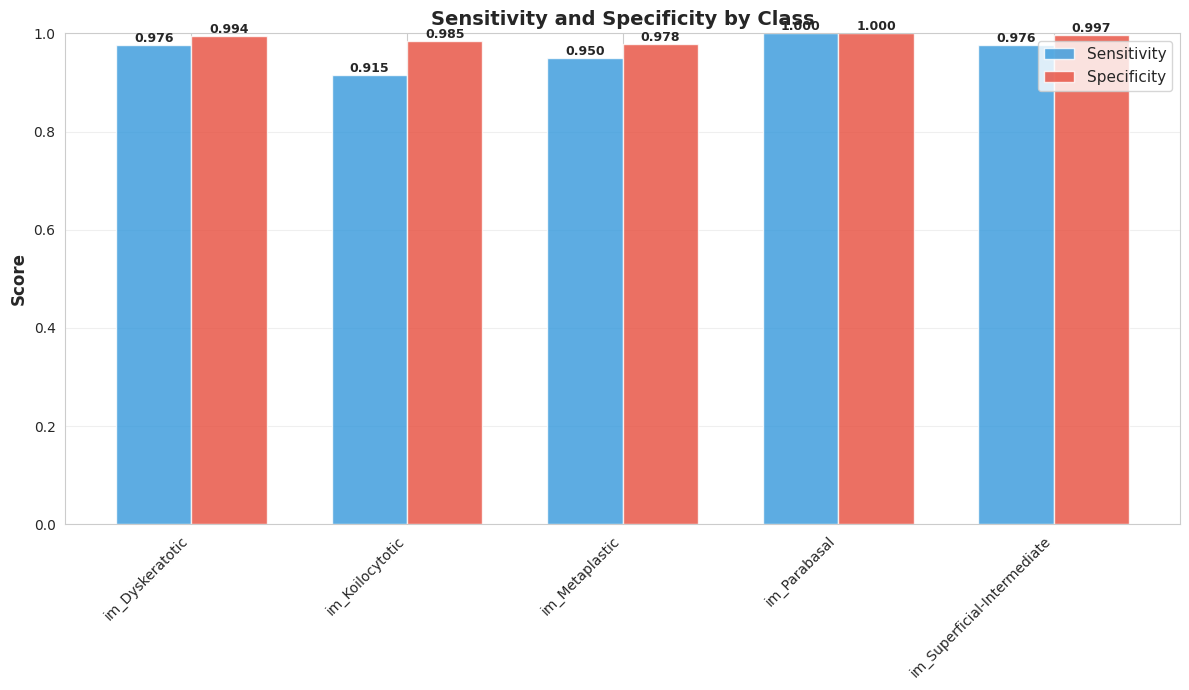

✓ Saved: evaluation_results/sensitivity_specificity.png


In [44]:
# Visualize sensitivity and specificity
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(class_names_sorted))
width = 0.35

bars1 = ax.bar(x - width/2, sensitivities, width, label='Sensitivity', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, specificities, width, label='Specificity', color='#e74c3c', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Sensitivity and Specificity by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_sorted, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'sensitivity_specificity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'sensitivity_specificity.png'}")


Generating visualizations for class: im_Dyskeratotic


TypeError: Wrong key type: '169' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

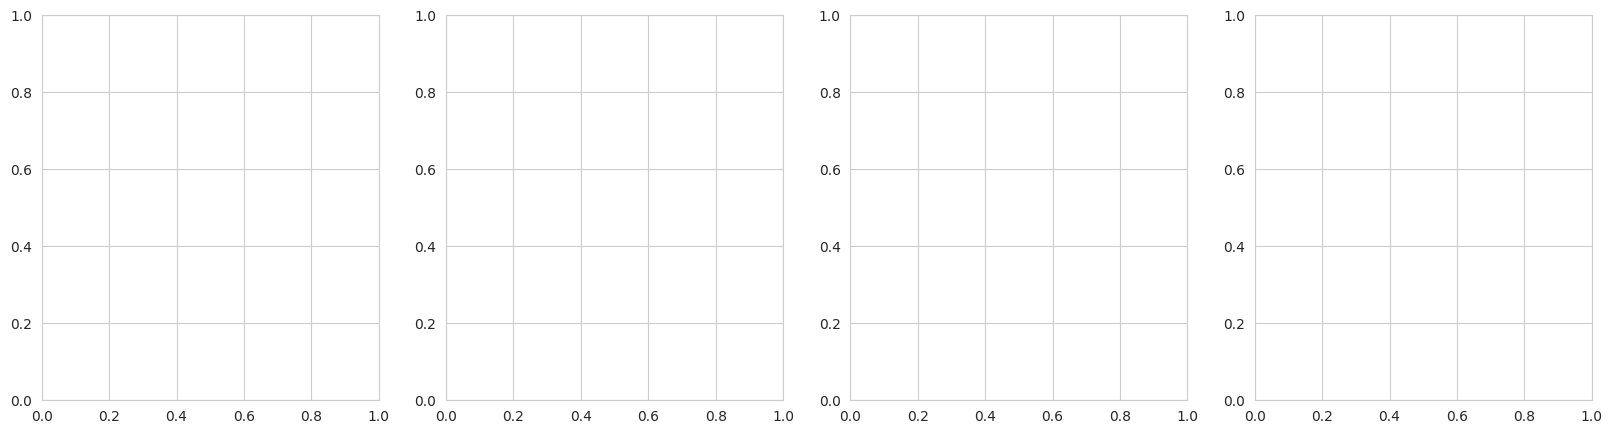

In [45]:
# Visualize sample predictions
# Show 3 correct predictions and 3 incorrect predictions per class (if available)

def denormalize_image(tensor, mean, std):
    """Denormalize image tensor for visualization"""
    img = tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img.clamp(0, 1)

# For each class, get some correct and incorrect predictions
n_samples_per_class = 2

for class_idx, class_name in enumerate(class_names_sorted):
    print(f"\nGenerating visualizations for class: {class_name}")

    # Find correct predictions
    correct_mask = (all_labels == class_idx) & (all_predictions == class_idx)
    correct_indices = np.where(correct_mask)[0]

    # Find incorrect predictions
    incorrect_mask = (all_labels == class_idx) & (all_predictions != class_idx)
    incorrect_indices = np.where(incorrect_mask)[0]

    # Sample indices
    n_correct = min(n_samples_per_class, len(correct_indices))
    n_incorrect = min(n_samples_per_class, len(incorrect_indices))

    if n_correct == 0 and n_incorrect == 0:
        print(f"  No samples found for {class_name}")
        continue

    selected_correct = np.random.choice(correct_indices, n_correct, replace=False) if n_correct > 0 else []
    selected_incorrect = np.random.choice(incorrect_indices, n_incorrect, replace=False) if n_incorrect > 0 else []

    # Create figure
    n_total = n_correct + n_incorrect
    fig, axes = plt.subplots(1, n_total, figsize=(5*n_total, 5))
    if n_total == 1:
        axes = [axes]

    idx = 0

    # Plot correct predictions
    for sample_idx in selected_correct:
        # Get image
        pixel_values = eval_dataset[sample_idx]['pixel_values']
        img = denormalize_image(pixel_values, mean, std)
        img_np = img.permute(1, 2, 0).numpy()

        axes[idx].imshow(img_np)
        axes[idx].set_title(f"✓ CORRECT\nTrue: {class_name}\nConf: {all_probabilities[sample_idx, class_idx]:.3f}",
                           color='green', fontweight='bold')
        axes[idx].axis('off')
        idx += 1

    # Plot incorrect predictions
    for sample_idx in selected_incorrect:
        # Get image
        pixel_values = eval_dataset[sample_idx]['pixel_values']
        img = denormalize_image(pixel_values, mean, std)
        img_np = img.permute(1, 2, 0).numpy()

        pred_class = all_predictions[sample_idx]
        axes[idx].imshow(img_np)
        axes[idx].set_title(f"✗ INCORRECT\nTrue: {class_name}\nPred: {class_names_sorted[pred_class]}\nConf: {all_probabilities[sample_idx, pred_class]:.3f}",
                           color='red', fontweight='bold')
        axes[idx].axis('off')
        idx += 1

    plt.suptitle(f'Sample Predictions for {class_name}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'samples_{class_name}.png', dpi=200, bbox_inches='tight')
    plt.show()

    print(f"  ✓ Saved: {OUTPUT_DIR / f'samples_{class_name}.png'}")

In [46]:
# Generate comprehensive summary report
summary_report = f"""
{'='*80}
COMPREHENSIVE MODEL EVALUATION SUMMARY REPORT
{'='*80}

Model: ConvNeXt V2 Fine-tuned on Sipakmed Dataset
Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Test Set Size: {len(all_labels)} samples
Number of Classes: {n_classes}

{'='*80}
OVERALL PERFORMANCE
{'='*80}

Accuracy:                    {accuracy:.4f} ({accuracy*100:.2f}%)
Balanced Accuracy:           {balanced_acc:.4f}

Precision (Macro):           {precision_macro:.4f}
Precision (Weighted):        {precision_weighted:.4f}

Recall (Macro):              {recall_macro:.4f}
Recall (Weighted):           {recall_weighted:.4f}

F1-Score (Macro):            {f1_macro:.4f}
F1-Score (Weighted):         {f1_weighted:.4f}

{'='*80}
ADVANCED METRICS
{'='*80}

Cohen's Kappa:               {kappa:.4f}
Matthews Correlation Coef:   {mcc:.4f}

ROC AUC (Micro):             {roc_auc['micro']:.4f}
ROC AUC (Macro):             {roc_auc['macro']:.4f}

Avg Precision (Micro):       {avg_precision['micro']:.4f}
Avg Precision (Macro):       {avg_precision['macro']:.4f}

Average Sensitivity:         {np.mean(sensitivities):.4f}
Average Specificity:         {np.mean(specificities):.4f}

{'='*80}
TOP-K ACCURACY
{'='*80}

"""

for k, acc in enumerate(topk_accuracies, 1):
    summary_report += f"Top-{k} Accuracy:              {acc:.4f} ({acc*100:.2f}%)\n"

summary_report += f"""
{'='*80}
PER-CLASS PERFORMANCE
{'='*80}

"""

for i, class_name in enumerate(class_names_sorted):
    summary_report += f"""
{class_name}:
  Support:        {int(class_metrics.loc[class_name, 'support'])}
  Precision:      {class_metrics.loc[class_name, 'precision']:.4f}
  Recall:         {class_metrics.loc[class_name, 'recall']:.4f}
  F1-Score:       {class_metrics.loc[class_name, 'f1-score']:.4f}
  ROC AUC:        {roc_auc[i]:.4f}
  Avg Precision:  {avg_precision[i]:.4f}
  Sensitivity:    {sensitivities[i]:.4f}
  Specificity:    {specificities[i]:.4f}
"""

summary_report += f"""
{'='*80}
ERROR ANALYSIS
{'='*80}

Total Samples:               {len(all_labels)}
Correctly Classified:        {len(correctly_classified_indices)} ({len(correctly_classified_indices)/len(all_labels)*100:.2f}%)
Misclassified:               {len(misclassified_indices)} ({len(misclassified_indices)/len(all_labels)*100:.2f}%)

Avg Confidence (Correct):    {correct_confidences.mean():.4f} ± {correct_confidences.std():.4f}
Avg Confidence (Incorrect):  {incorrect_confidences.mean():.4f} ± {incorrect_confidences.std():.4f}

{'='*80}
FILES GENERATED
{'='*80}

1. overall_metrics.png - Overall performance metrics visualization
2. confusion_matrices.png - Confusion matrices (raw and normalized)
3. roc_curves.png - ROC curves for all classes
4. precision_recall_curves.png - Precision-Recall curves
5. per_class_metrics.png - Per-class performance metrics
6. misclassification_patterns.png - Misclassification heatmap
7. confidence_distribution.png - Confidence score distributions
8. topk_accuracy.png - Top-K accuracy visualization
9. sensitivity_specificity.png - Sensitivity and specificity by class
10. samples_[class].png - Sample predictions for each class
11. classification_report.csv - Detailed classification report
12. misclassifications.csv - All misclassified samples
13. evaluation_summary.txt - This summary report

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save summary report
with open(OUTPUT_DIR / 'evaluation_summary.txt', 'w') as f:
    f.write(summary_report)

print(f"\n✓ Saved: {OUTPUT_DIR / 'evaluation_summary.txt'}")


COMPREHENSIVE MODEL EVALUATION SUMMARY REPORT

Model: ConvNeXt V2 Fine-tuned on Sipakmed Dataset
Date: 2025-11-21 22:51:53
Test Set Size: 405 samples
Number of Classes: 5

OVERALL PERFORMANCE

Accuracy:                    0.9630 (96.30%)
Balanced Accuracy:           0.9632

Precision (Macro):           0.9633
Precision (Weighted):        0.9632

Recall (Macro):              0.9632
Recall (Weighted):           0.9630

F1-Score (Macro):            0.9632
F1-Score (Weighted):         0.9630

ADVANCED METRICS

Cohen's Kappa:               0.9537
Matthews Correlation Coef:   0.9538

ROC AUC (Micro):             0.9949
ROC AUC (Macro):             0.9958

Avg Precision (Micro):       0.9867
Avg Precision (Macro):       0.9852

Average Sensitivity:         0.9632
Average Specificity:         0.9907

TOP-K ACCURACY

Top-1 Accuracy:              0.9630 (96.30%)
Top-2 Accuracy:              0.9901 (99.01%)
Top-3 Accuracy:              0.9975 (99.75%)

PER-CLASS PERFORMANCE


im_Dyskeratotic:
  